## Settings

In [1]:
import os
import sys
from sys import platform
BASE_PATH = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(BASE_PATH+'\src' if platform == 'win32' else BASE_PATH+'/src')
from config.global_config import get_global_config
from helper.utils import get_hp_outcome
from helper.printing import print_durations, print_best_metrics
from helper.plotting import plot_results, plot_tradeoff, plot_tradeoff_by_increment, plot_power, plot_increments_by_metrics

In [2]:
_config = get_global_config()
HP_CONFIG_PATH = os.path.join(BASE_PATH, _config.get('HP_CONFIG_PATH'))
RESULTS_PATH = os.path.join(BASE_PATH, _config.get('RESULT_PATH'))
if platform == 'win32':
	HP_CONFIG_PATH = HP_CONFIG_PATH.replace('/', '\\')
	RESULTS_PATH = RESULTS_PATH.replace('/', '\\')

## Movielens

In [3]:
results, metrics, experiments, best = get_hp_outcome(dataset='movielens_1m', result_path=RESULTS_PATH)
print_durations(results, experiments, hp_config_path=HP_CONFIG_PATH)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET           MODEL         RUNs            DURATION      AVG DURATION

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

1    movielens_1m      BPR             27             2:33:35             05:41

2    movielens_1m      CFKG           162            21:35:43             07:59

3    movielens_1m      CKE            243     1 day, 18:13:35             10:25

4    movielens_1m      DMF             81            17:15:43             12:47

5    movielens_1m      ItemKNN        162             1:25:06             00:31

6    movielens_1m      KGNNLS         162     1 day, 17:50:50             15:29

7    movielens_1m      LINE           162            13:44:13             05:05

8    movielens_1m      LightGCN       216    2 days, 13:13:57             17:00

9    movielens_1m      MultiDAE       162            22:20:33             08:16

10   movielens_1m 

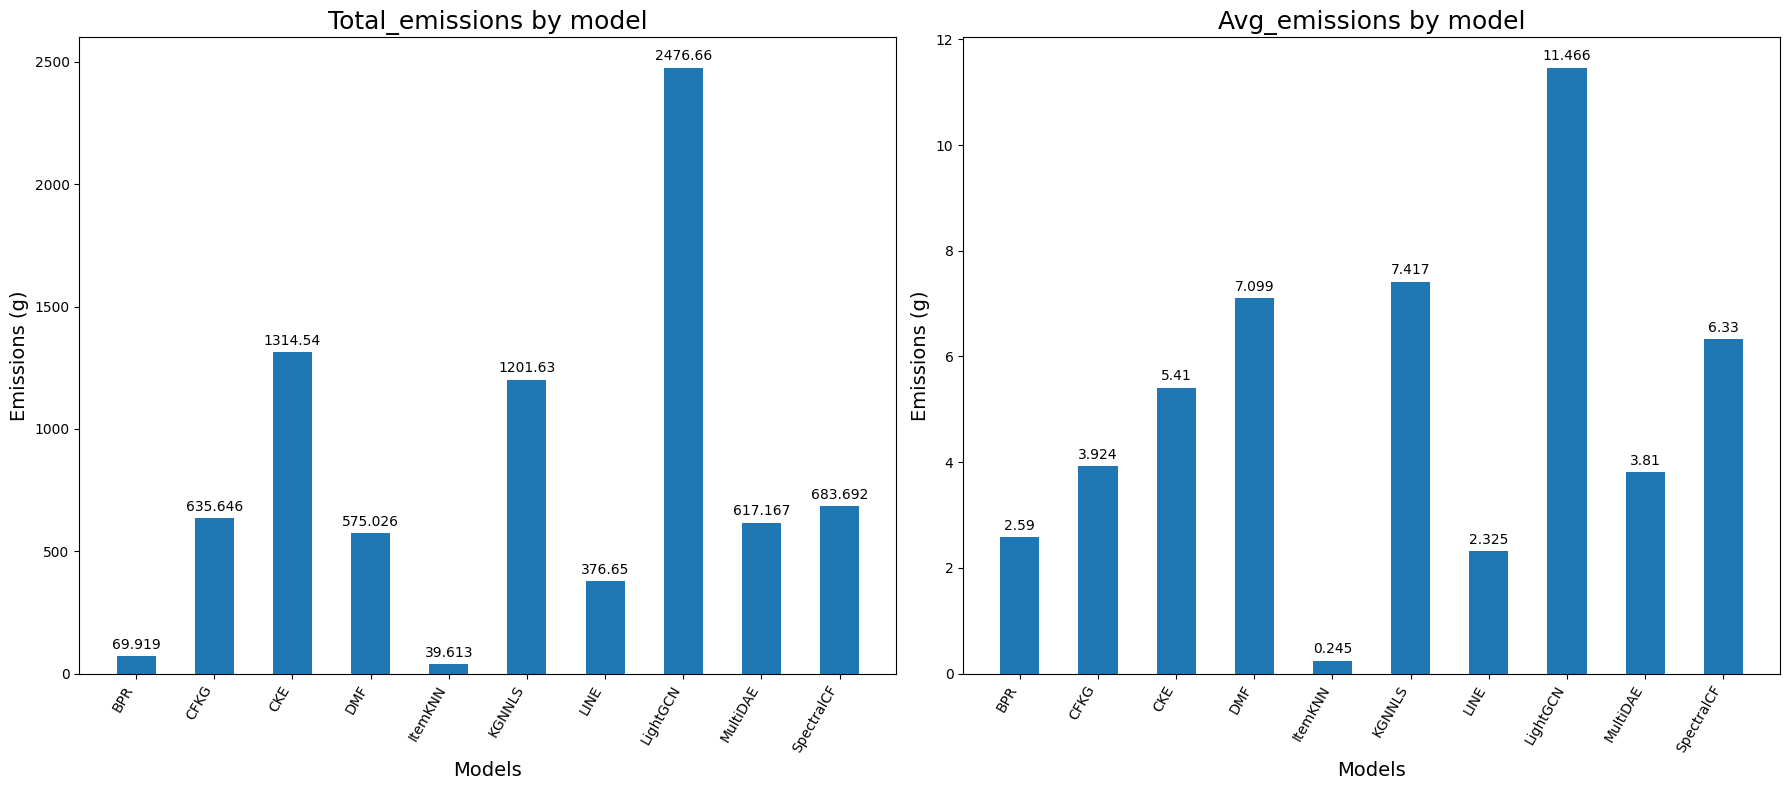

In [4]:
plot_results(results, experiments, hp_config_path=HP_CONFIG_PATH)

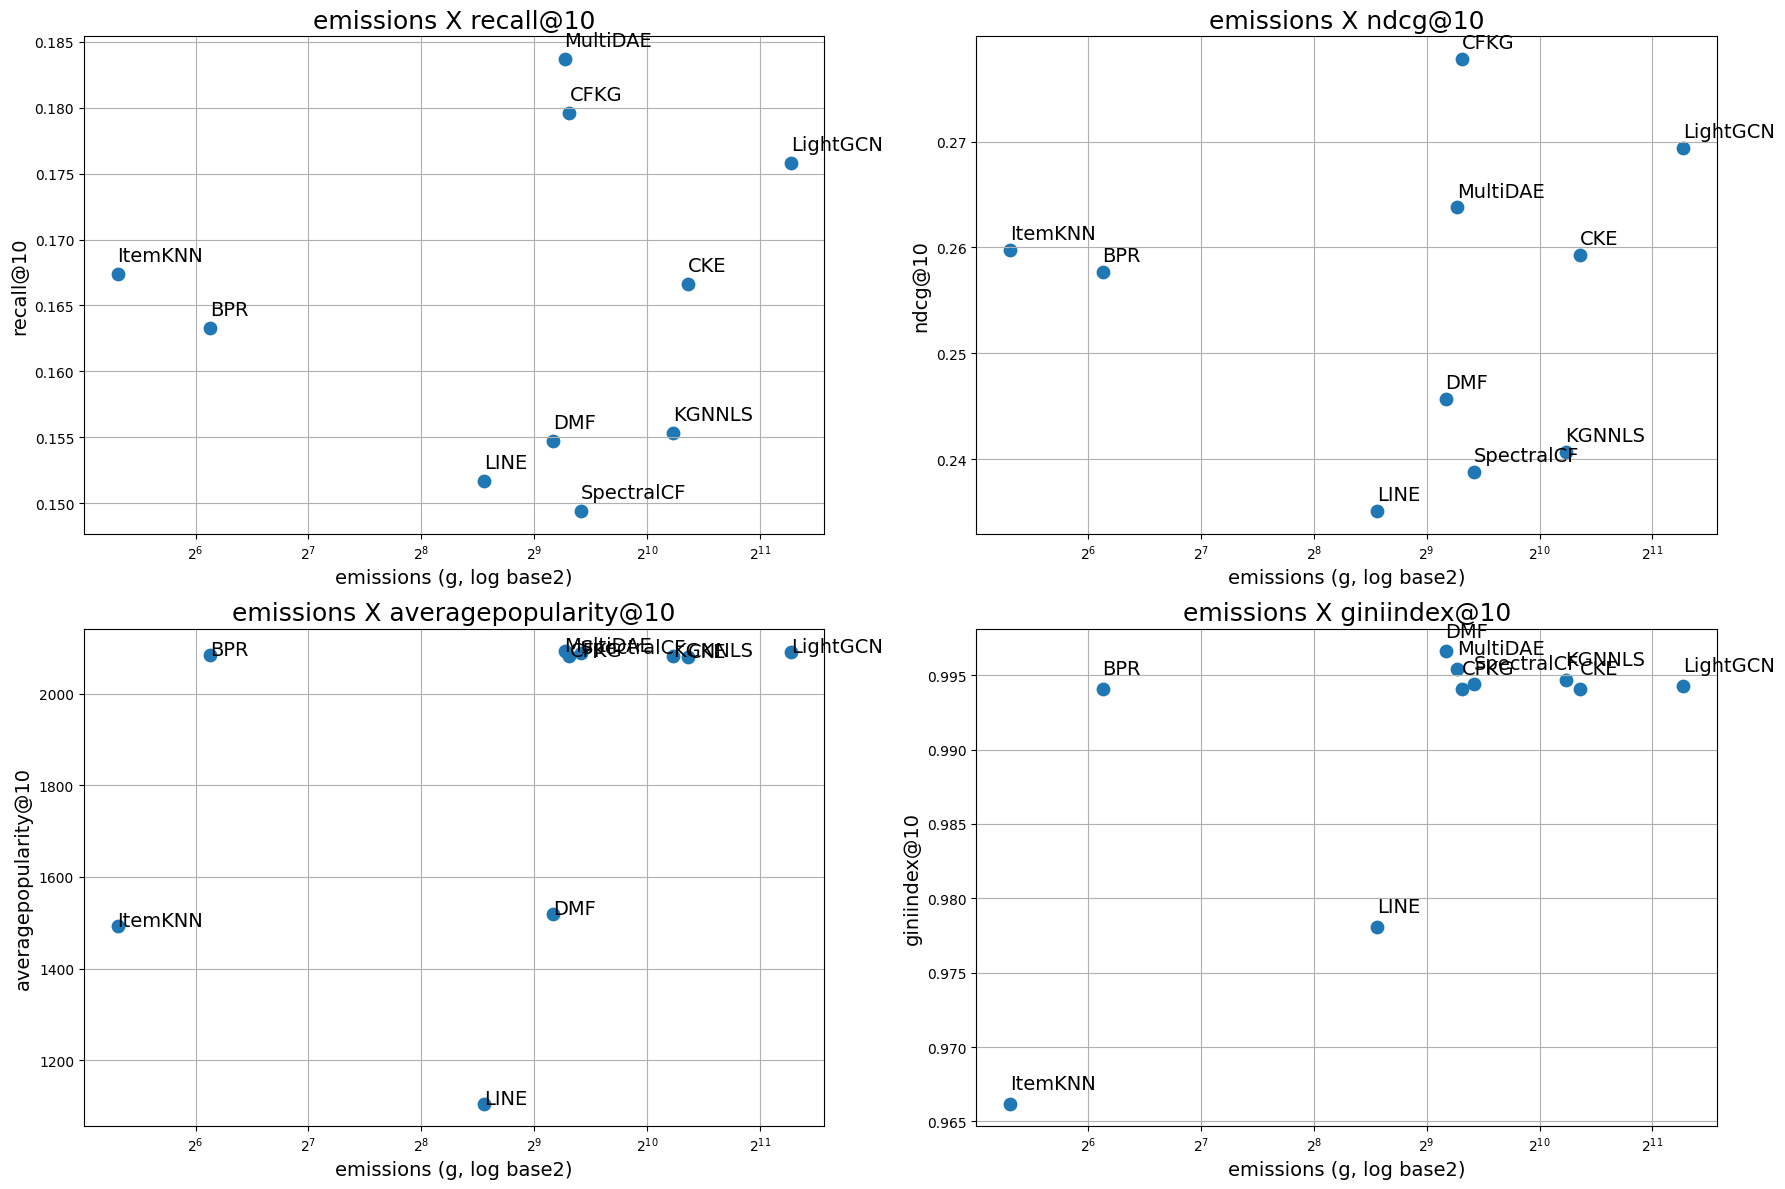

In [5]:
plot_tradeoff(results, metrics, experiments)

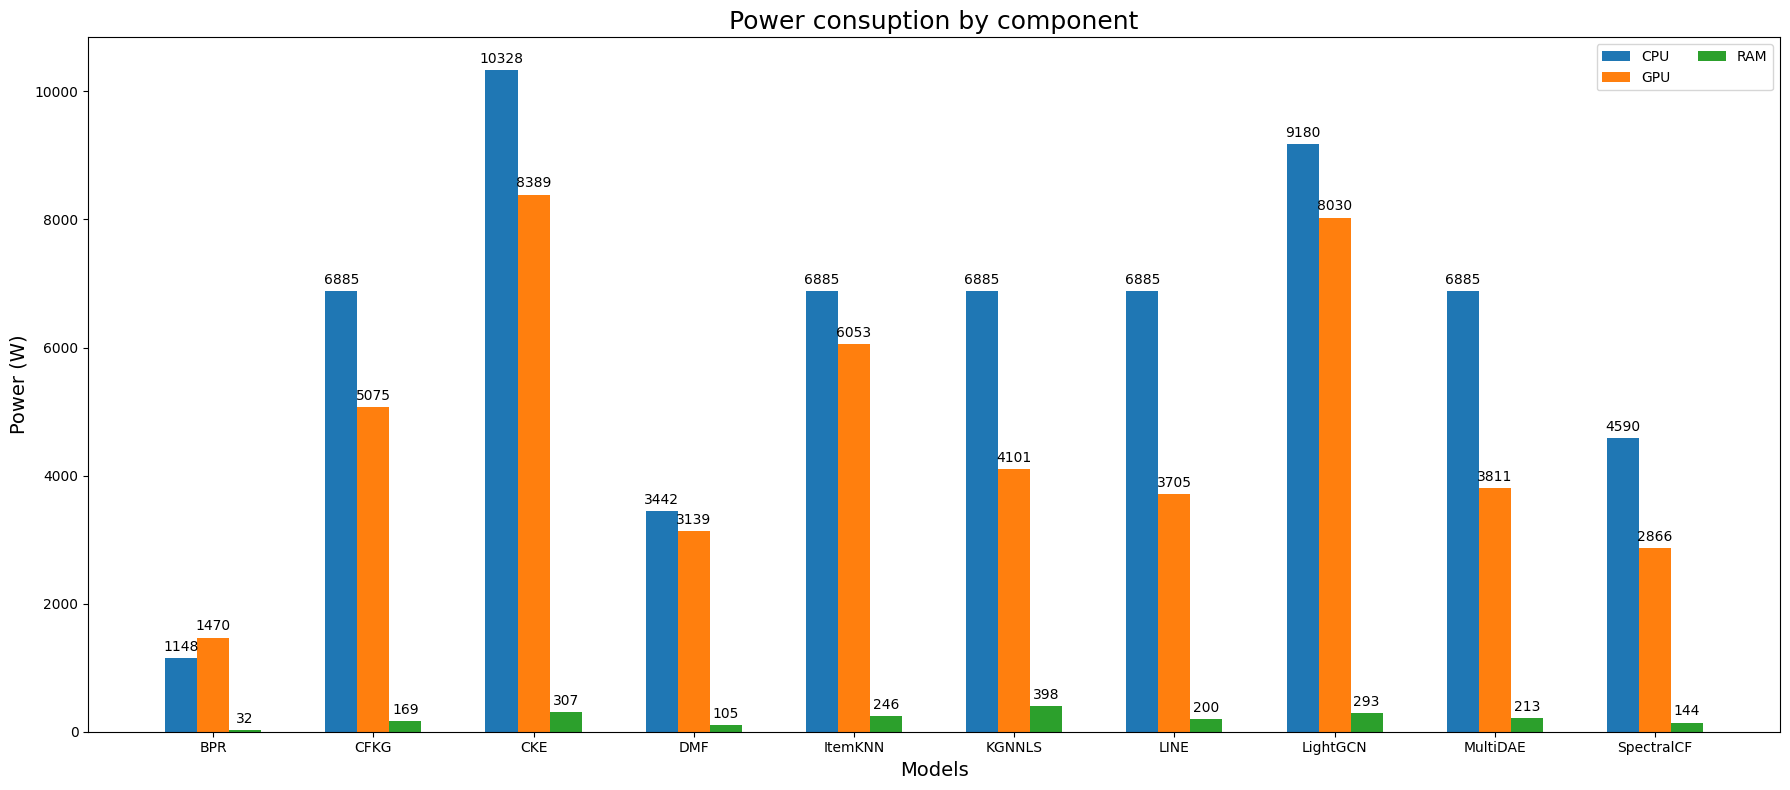

In [6]:
plot_power(results, experiments)

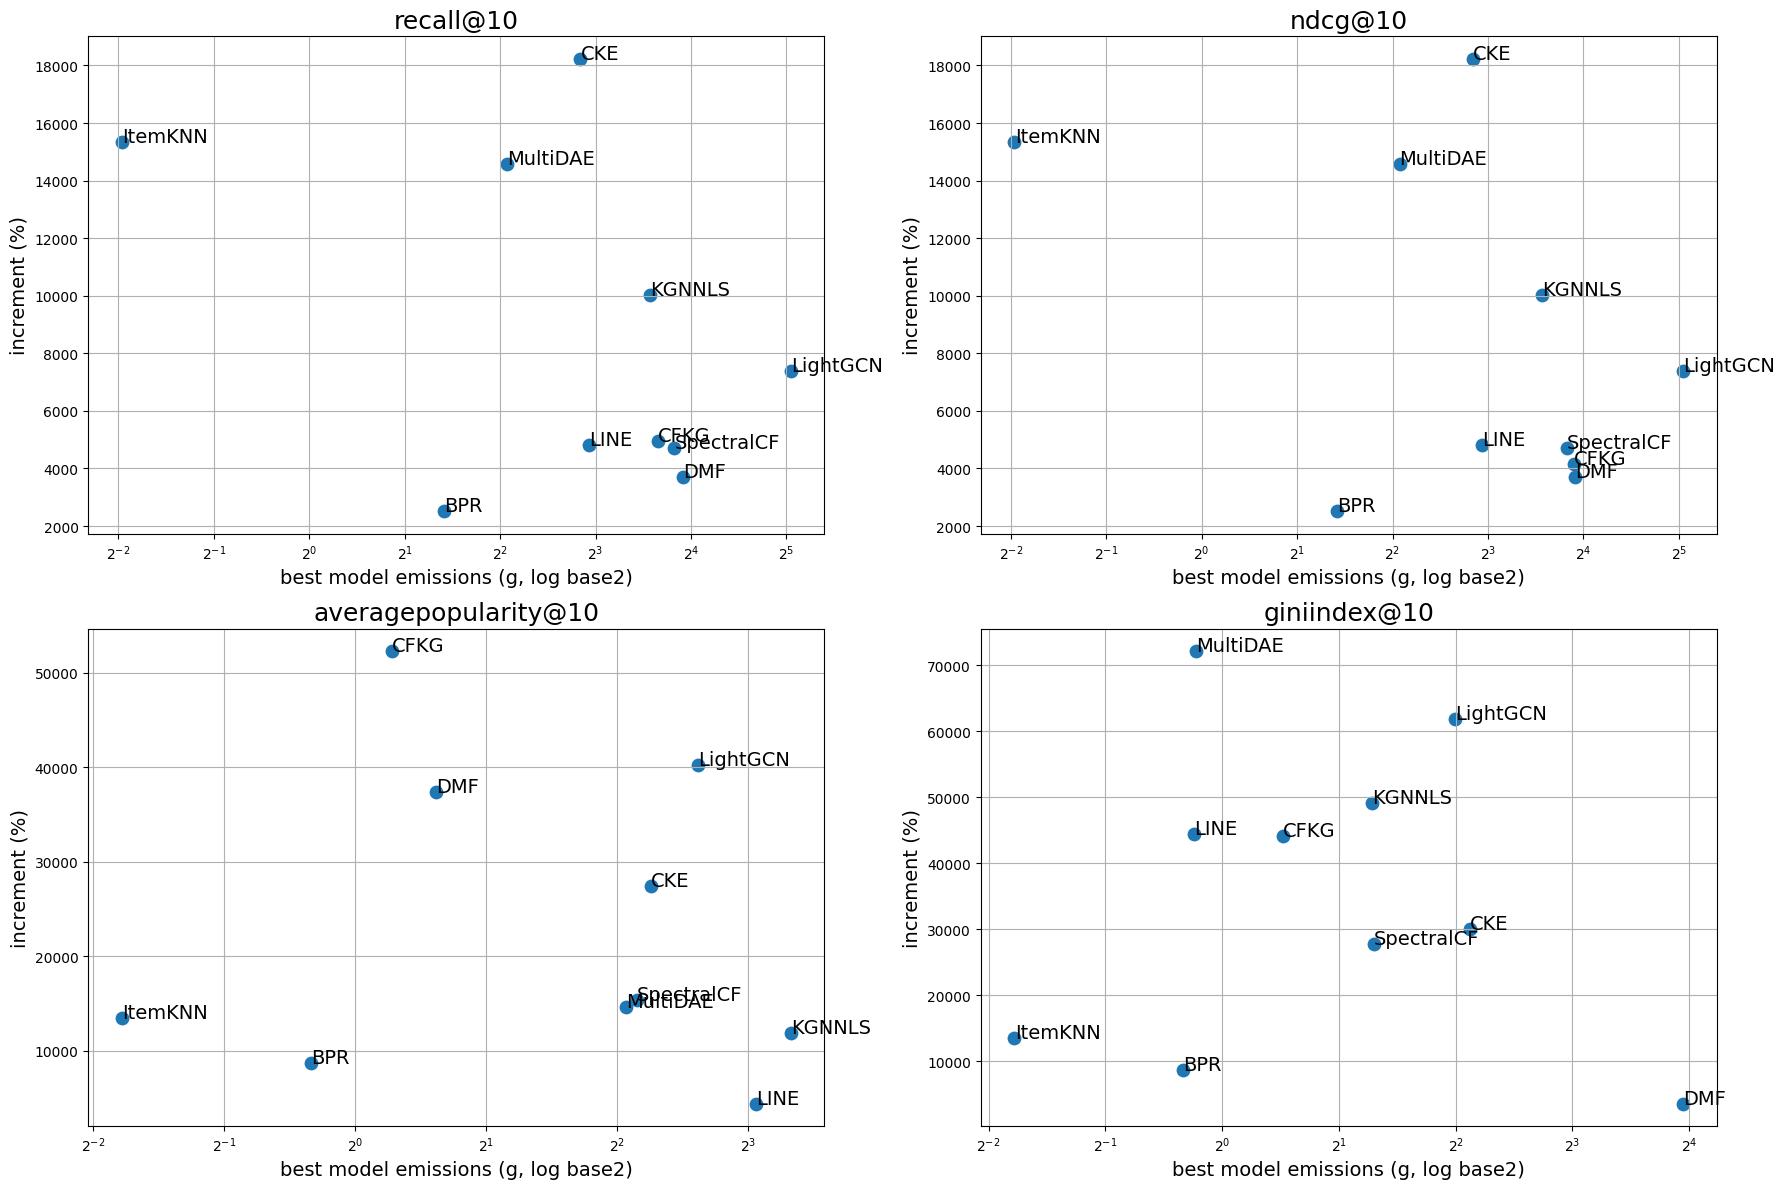

In [7]:
plot_tradeoff_by_increment(best, experiments)

In [8]:
print_best_metrics(results, best, experiments)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET      MODEL       BEST_METRIC by INCR.    BEST_RUN(g)       TOTAL(g)   INCREMENT(%)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
1    movielens_1m BPR         recall@10                    2.6664         69.919           2522
1    movielens_1m BPR         mrr@10                       2.6664         69.919           2522
1    movielens_1m BPR         ndcg@10                      2.6664         69.919           2522
1    movielens_1m BPR         hit@10                       2.6664         69.919           2522
1    movielens_1m BPR         map@10                       2.6664         69.919           2522
1    movielens_1m BPR         precision@10                 2.6664         69.919           2522
1    movielens_1m BPR         gauc                         2.6664         69.919           2522

2    movielens_1m CFKG     

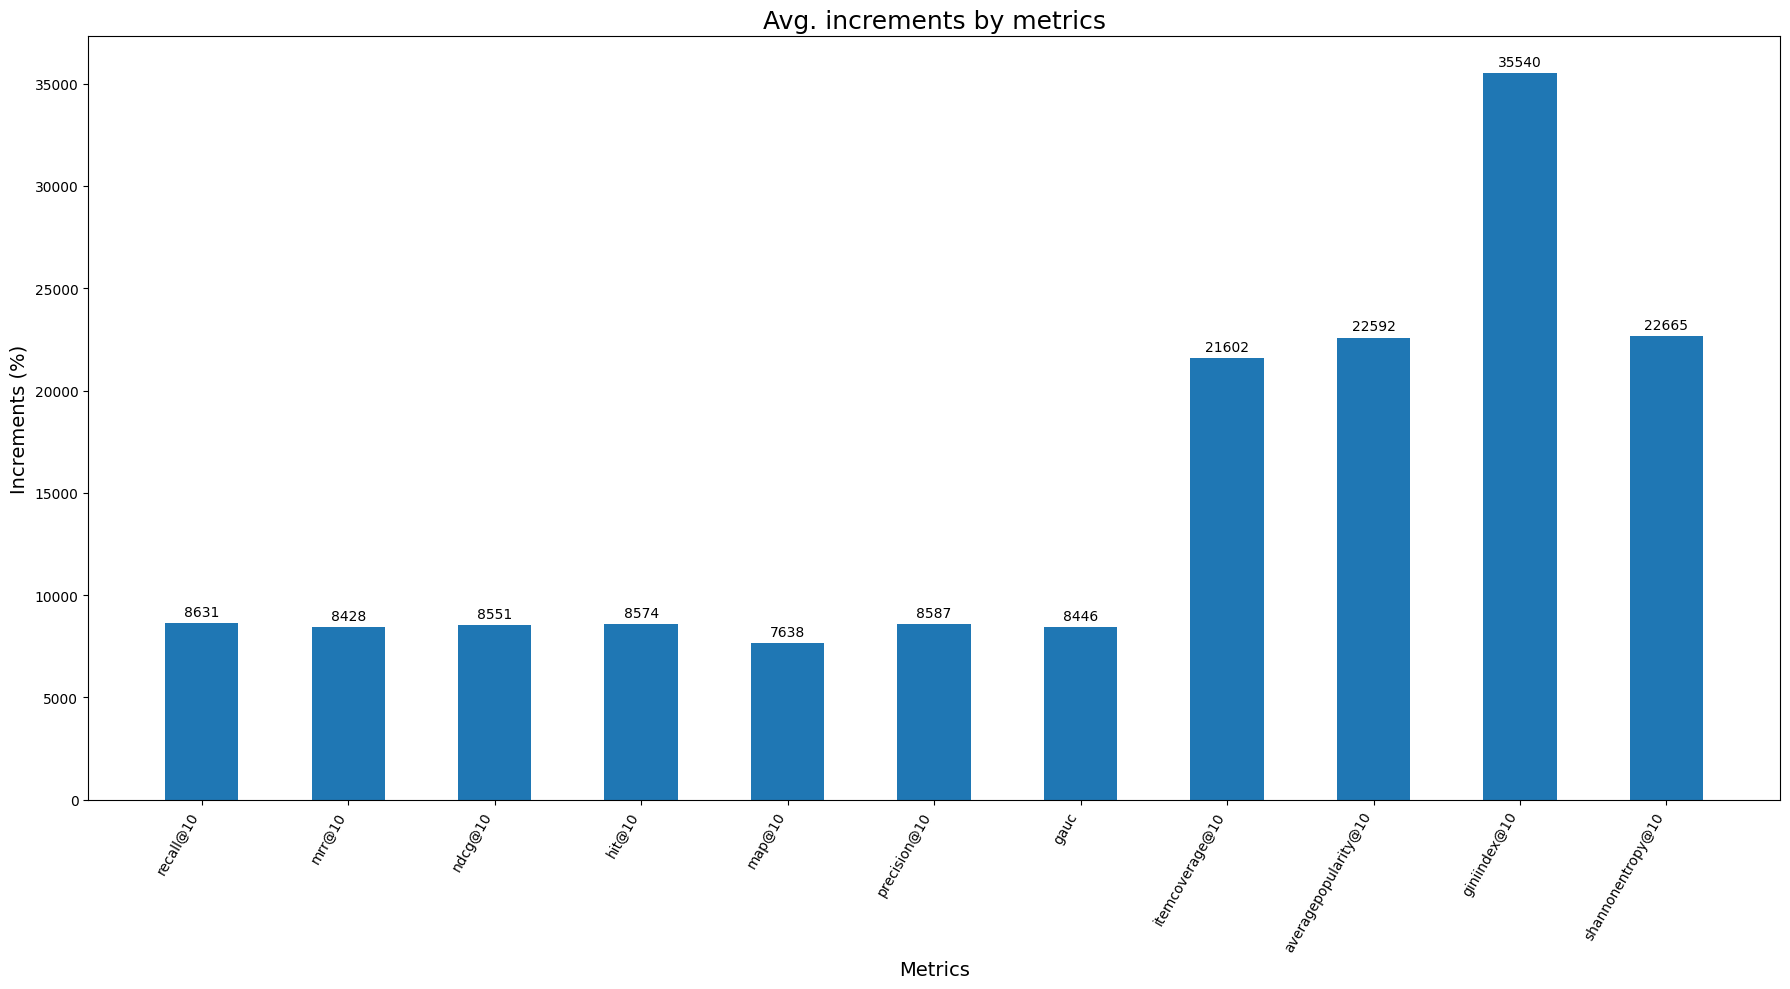

In [9]:
plot_increments_by_metrics(best)

## Mind

In [10]:
results, metrics, experiments, best = get_hp_outcome(dataset='mind', result_path=RESULTS_PATH)
print_durations(results, experiments, hp_config_path=HP_CONFIG_PATH)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET           MODEL         RUNs            DURATION      AVG DURATION

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

1    mind              BPR             27             7:56:17             17:38

2    mind              DMF             81     1 day, 12:52:59             27:19

3    mind              ItemKNN        162             4:58:28             01:50

4    mind              LINE           162     2 days, 0:18:31             17:53

5    mind              LightGCN       216    5 days, 12:44:48             36:52

6    mind              MultiDAE       162     3 days, 9:29:53             30:11

7    mind              SpectralCF     108     1 day, 21:34:11             25:18

     TOTAL:                               14 days, 21:55:12



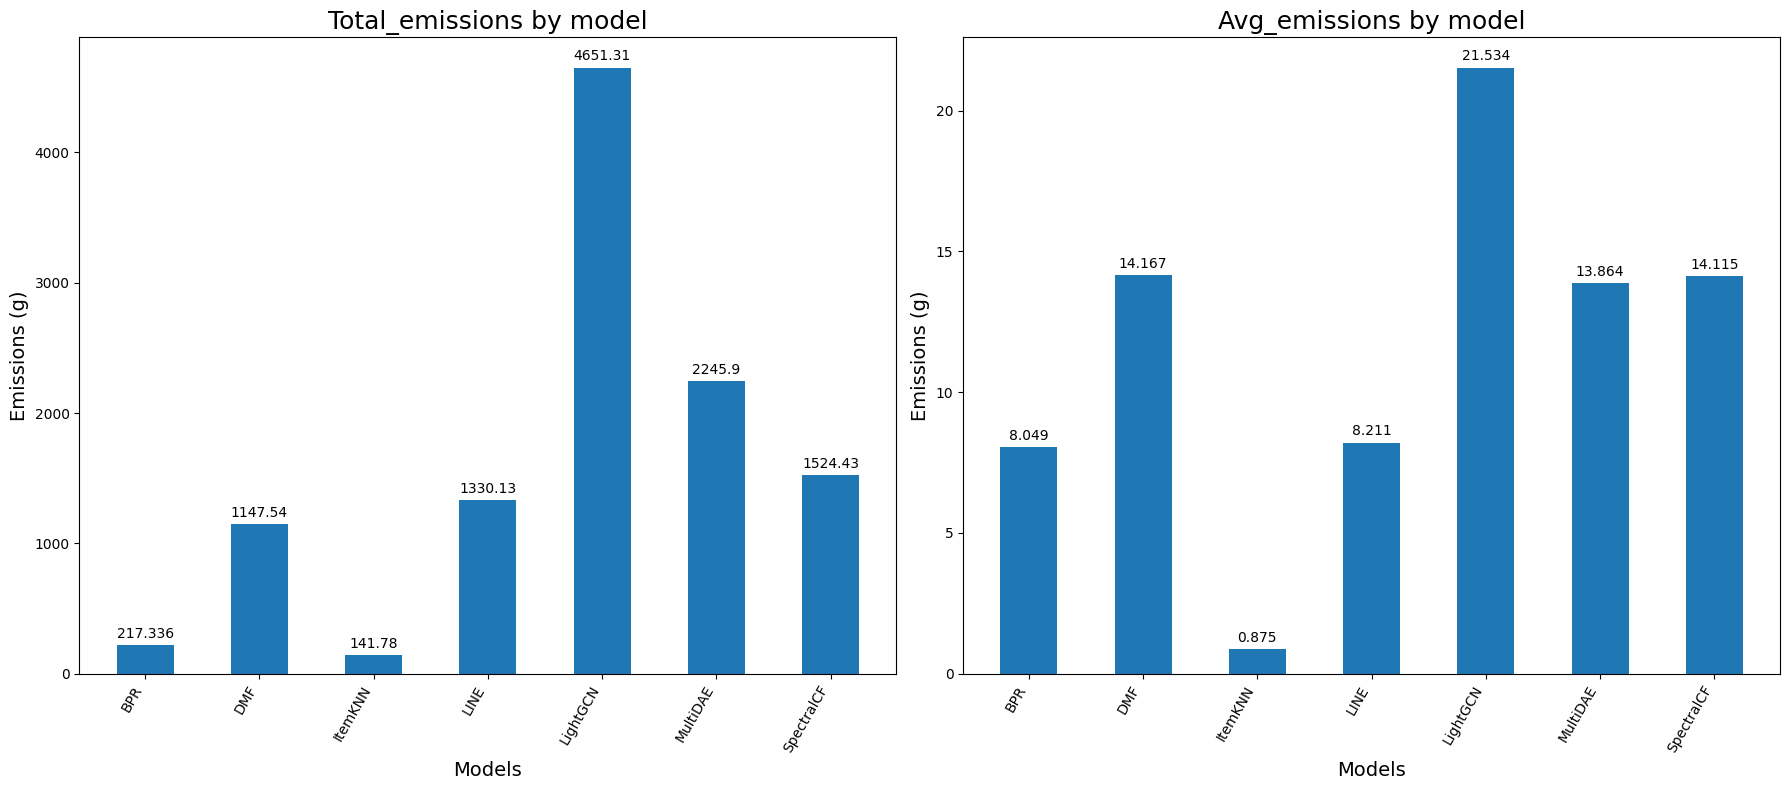

In [11]:
plot_results(results, experiments, hp_config_path=HP_CONFIG_PATH)

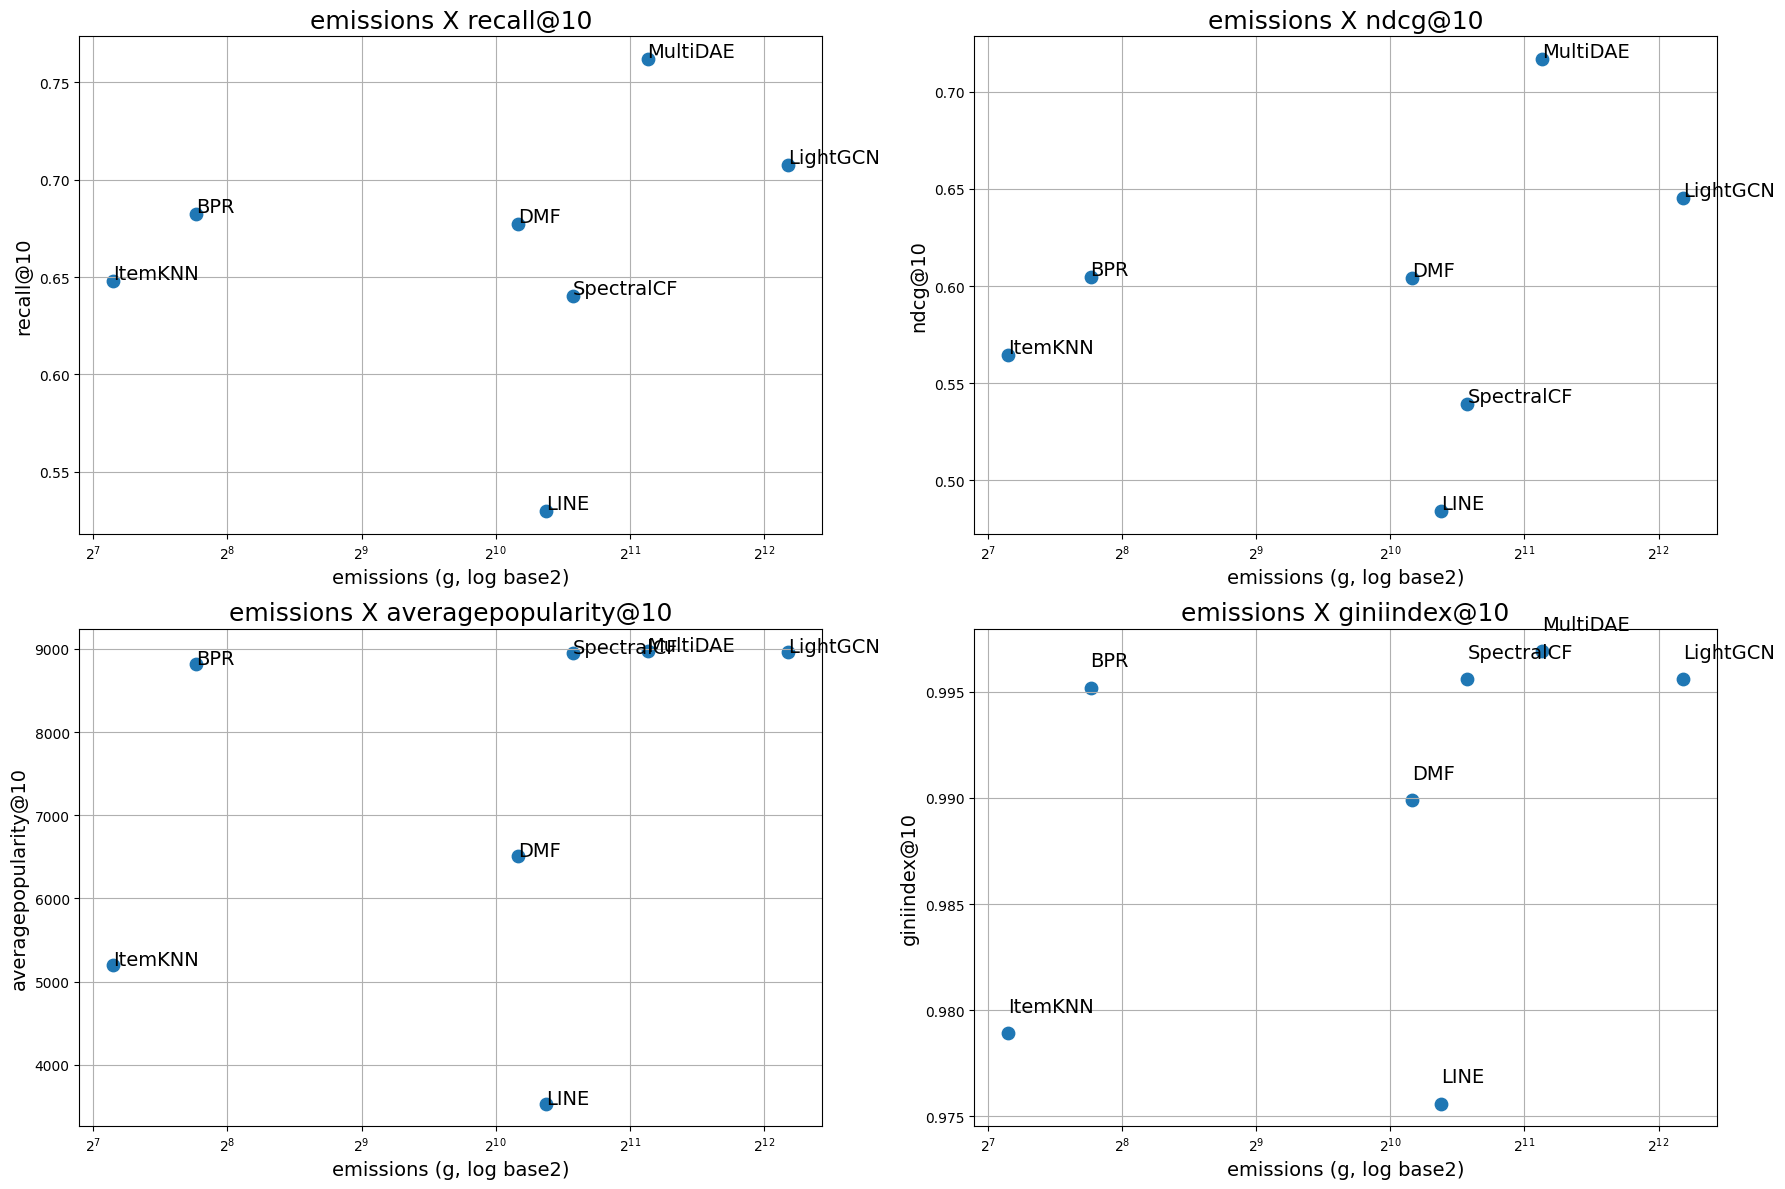

In [12]:
plot_tradeoff(results, metrics, experiments)

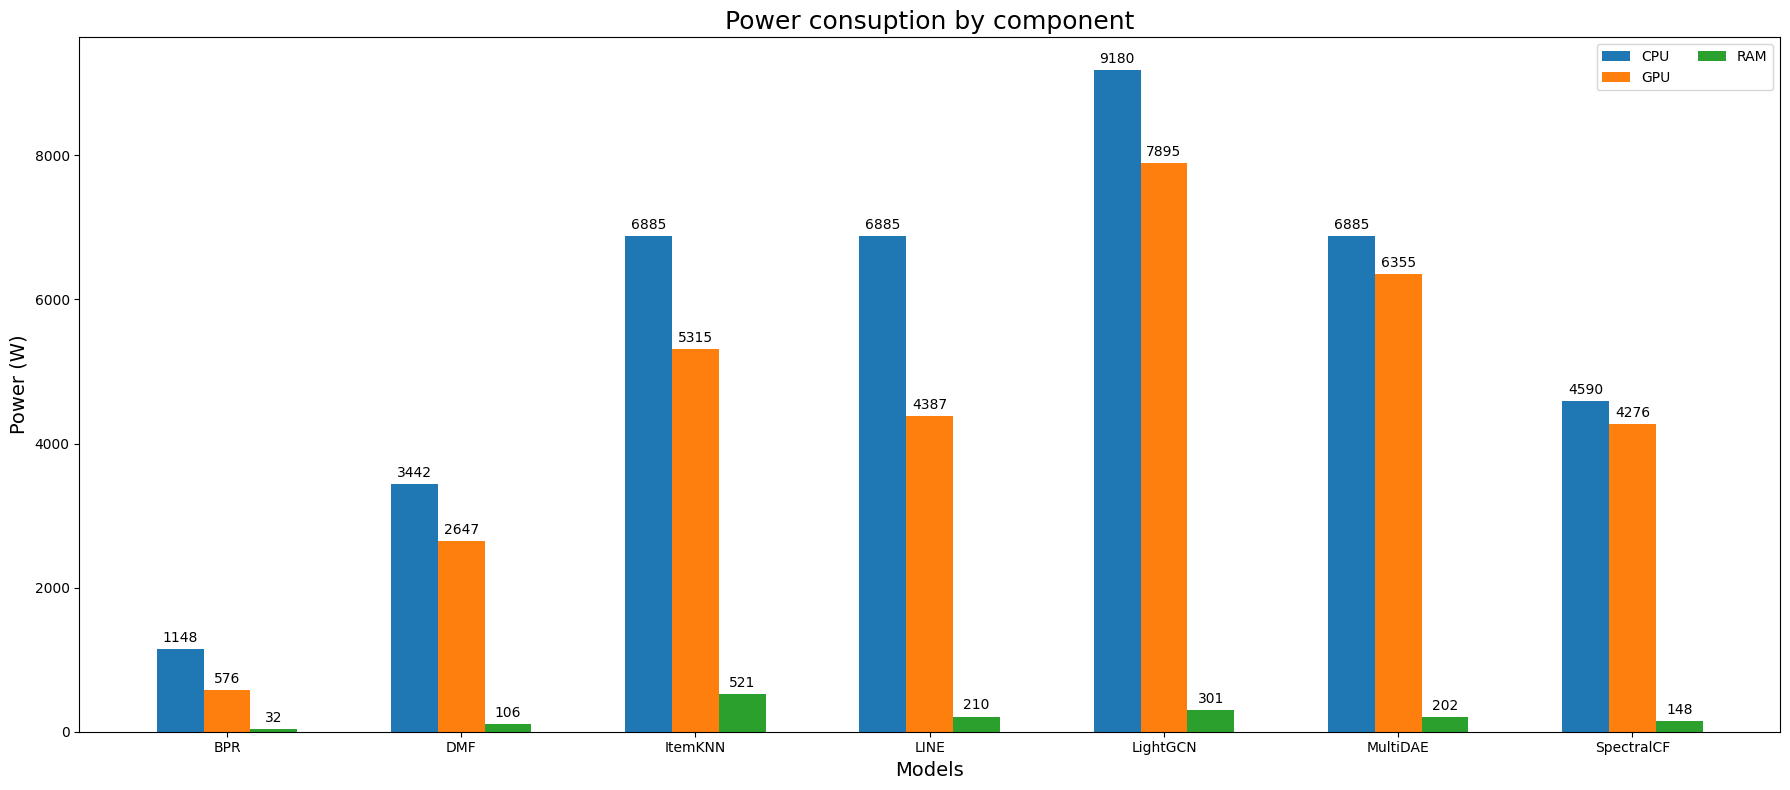

In [13]:
plot_power(results, experiments)

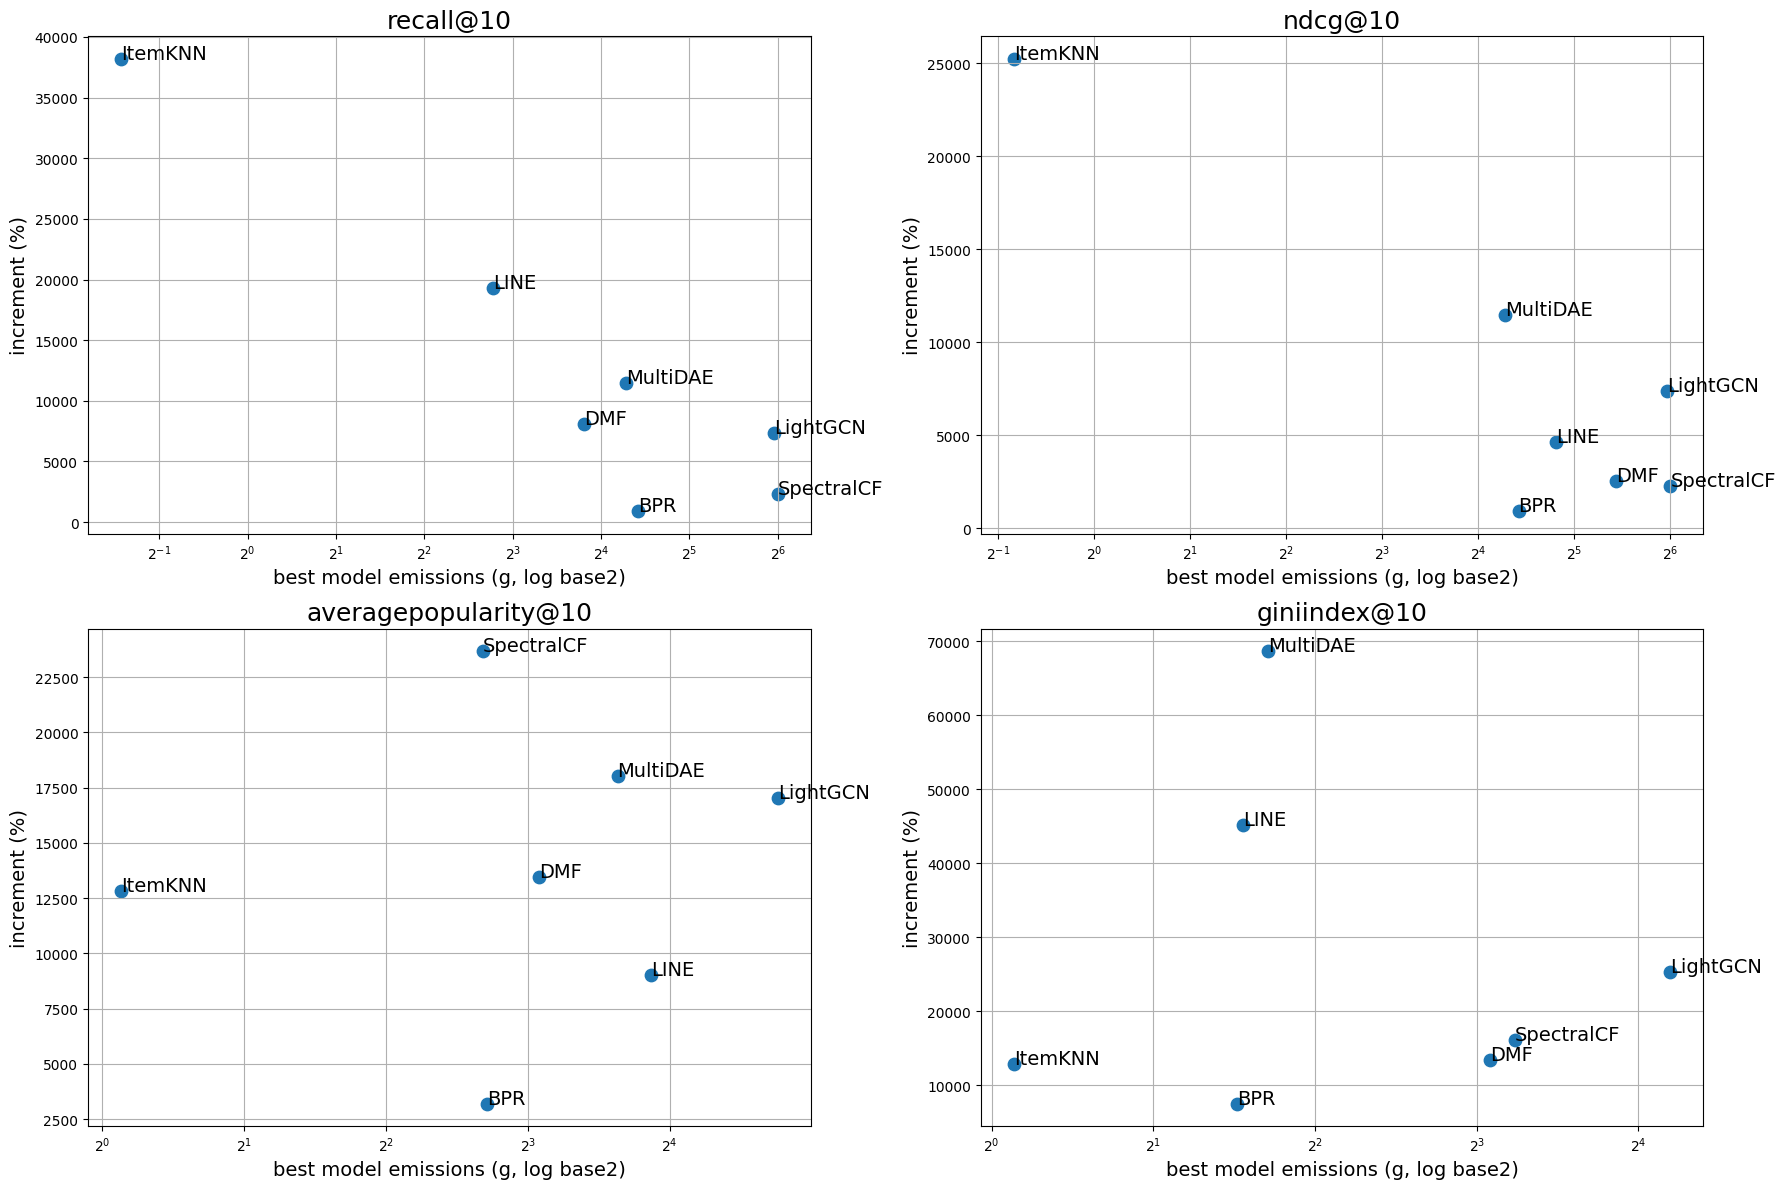

In [14]:
plot_tradeoff_by_increment(best, experiments)

In [15]:
print_best_metrics(results, best, experiments)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET      MODEL       BEST_METRIC by INCR.    BEST_RUN(g)       TOTAL(g)   INCREMENT(%)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
1    mind         BPR         recall@10                   21.4178        217.336            915
1    mind         BPR         mrr@10                      21.4178        217.336            915
1    mind         BPR         ndcg@10                     21.4178        217.336            915
1    mind         BPR         hit@10                      21.4178        217.336            915
1    mind         BPR         map@10                      21.4178        217.336            915
1    mind         BPR         precision@10                21.4178        217.336            915
1    mind         BPR         gauc                        21.4178        217.336            915

2    mind         DMF      

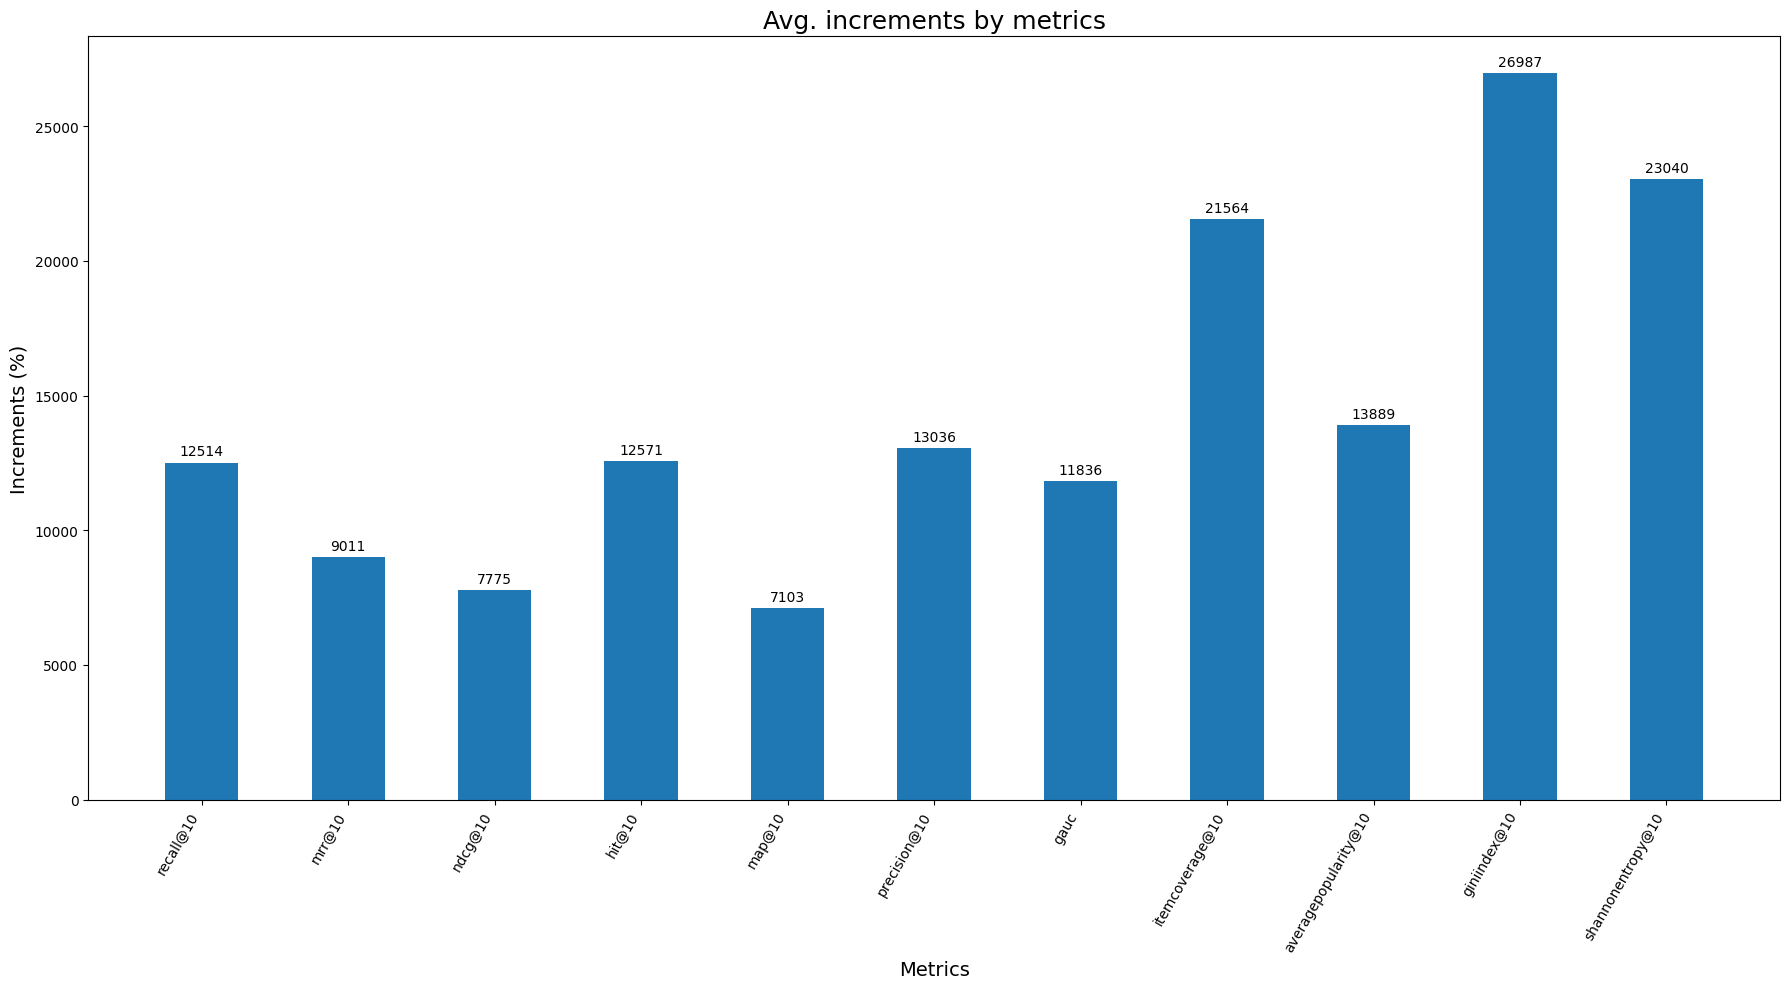

In [16]:
plot_increments_by_metrics(best)

## Amazon Books

In [17]:
results, metrics, experiments, best = get_hp_outcome(dataset='amazon_books_60core_kg', result_path=RESULTS_PATH)
print_durations(results, experiments, hp_config_path=HP_CONFIG_PATH)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET           MODEL         RUNs            DURATION      AVG DURATION

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

1    amazon_books      BPR             27            19:56:04             44:17

2    amazon_books      CFKG           162     3 days, 8:27:56             29:48

3    amazon_books      CKE            243    3 days, 19:11:17             22:30

4    amazon_books      DMF             81    2 days, 11:52:13             44:20

5    amazon_books      ItemKNN        162            18:54:58             07:00

6    amazon_books      KGNNLS         162     9 days, 1:50:56             20:41

7    amazon_books      LINE           162     4 days, 7:35:54             38:22

8    amazon_books      LightGCN       216   12 days, 18:04:46             25:01

9    amazon_books      MultiDAE       162     5 days, 2:03:14             45:12

10   amazon_books 

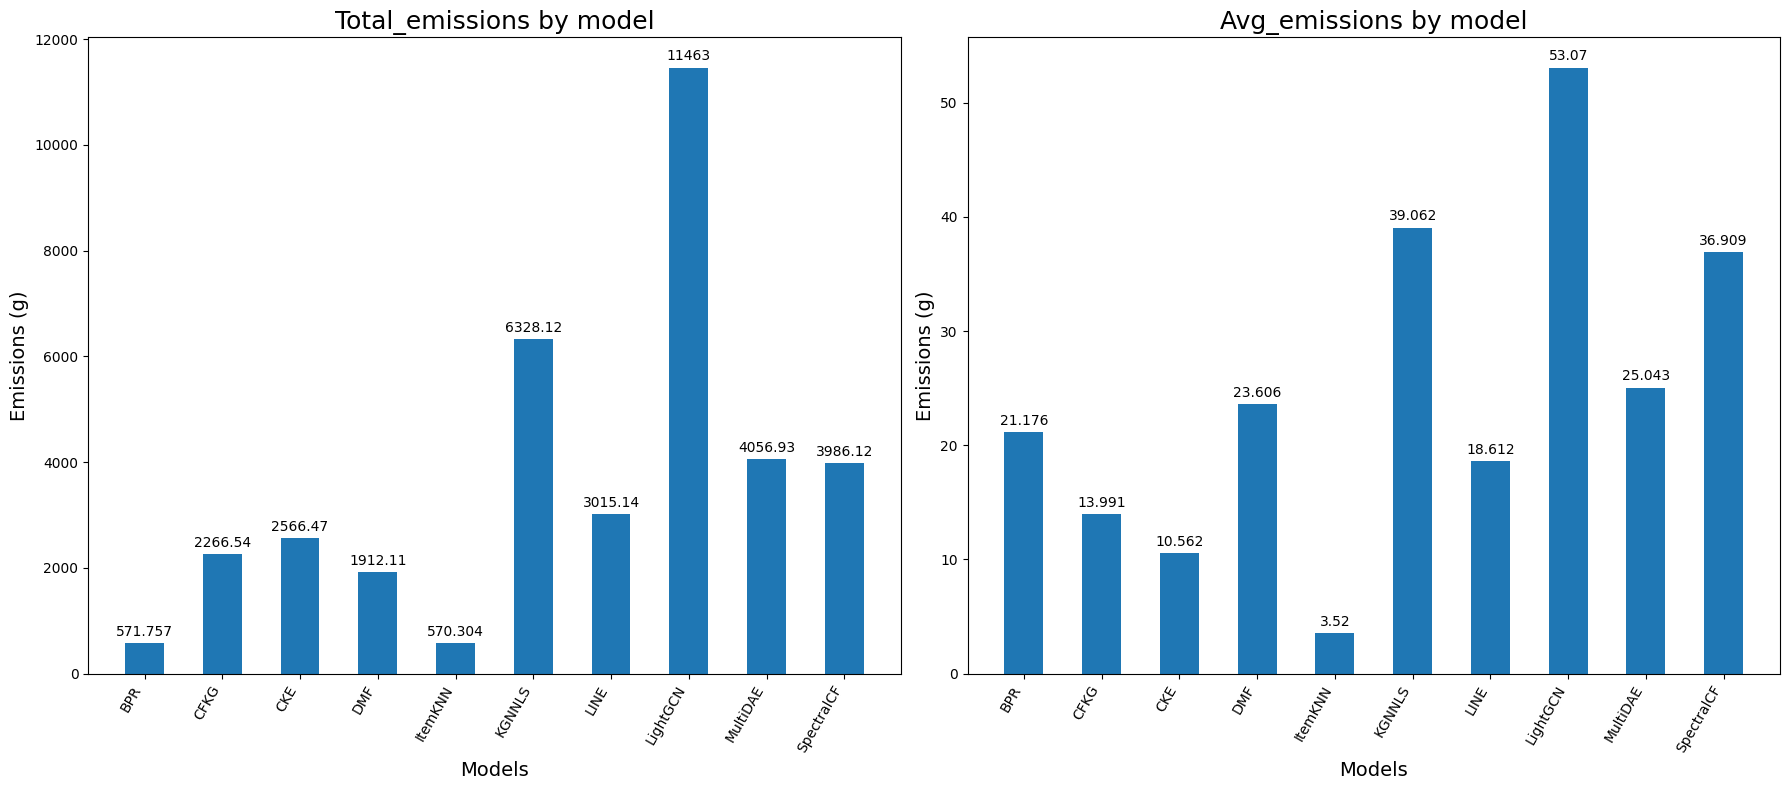

In [18]:
plot_results(results, experiments, hp_config_path=HP_CONFIG_PATH)

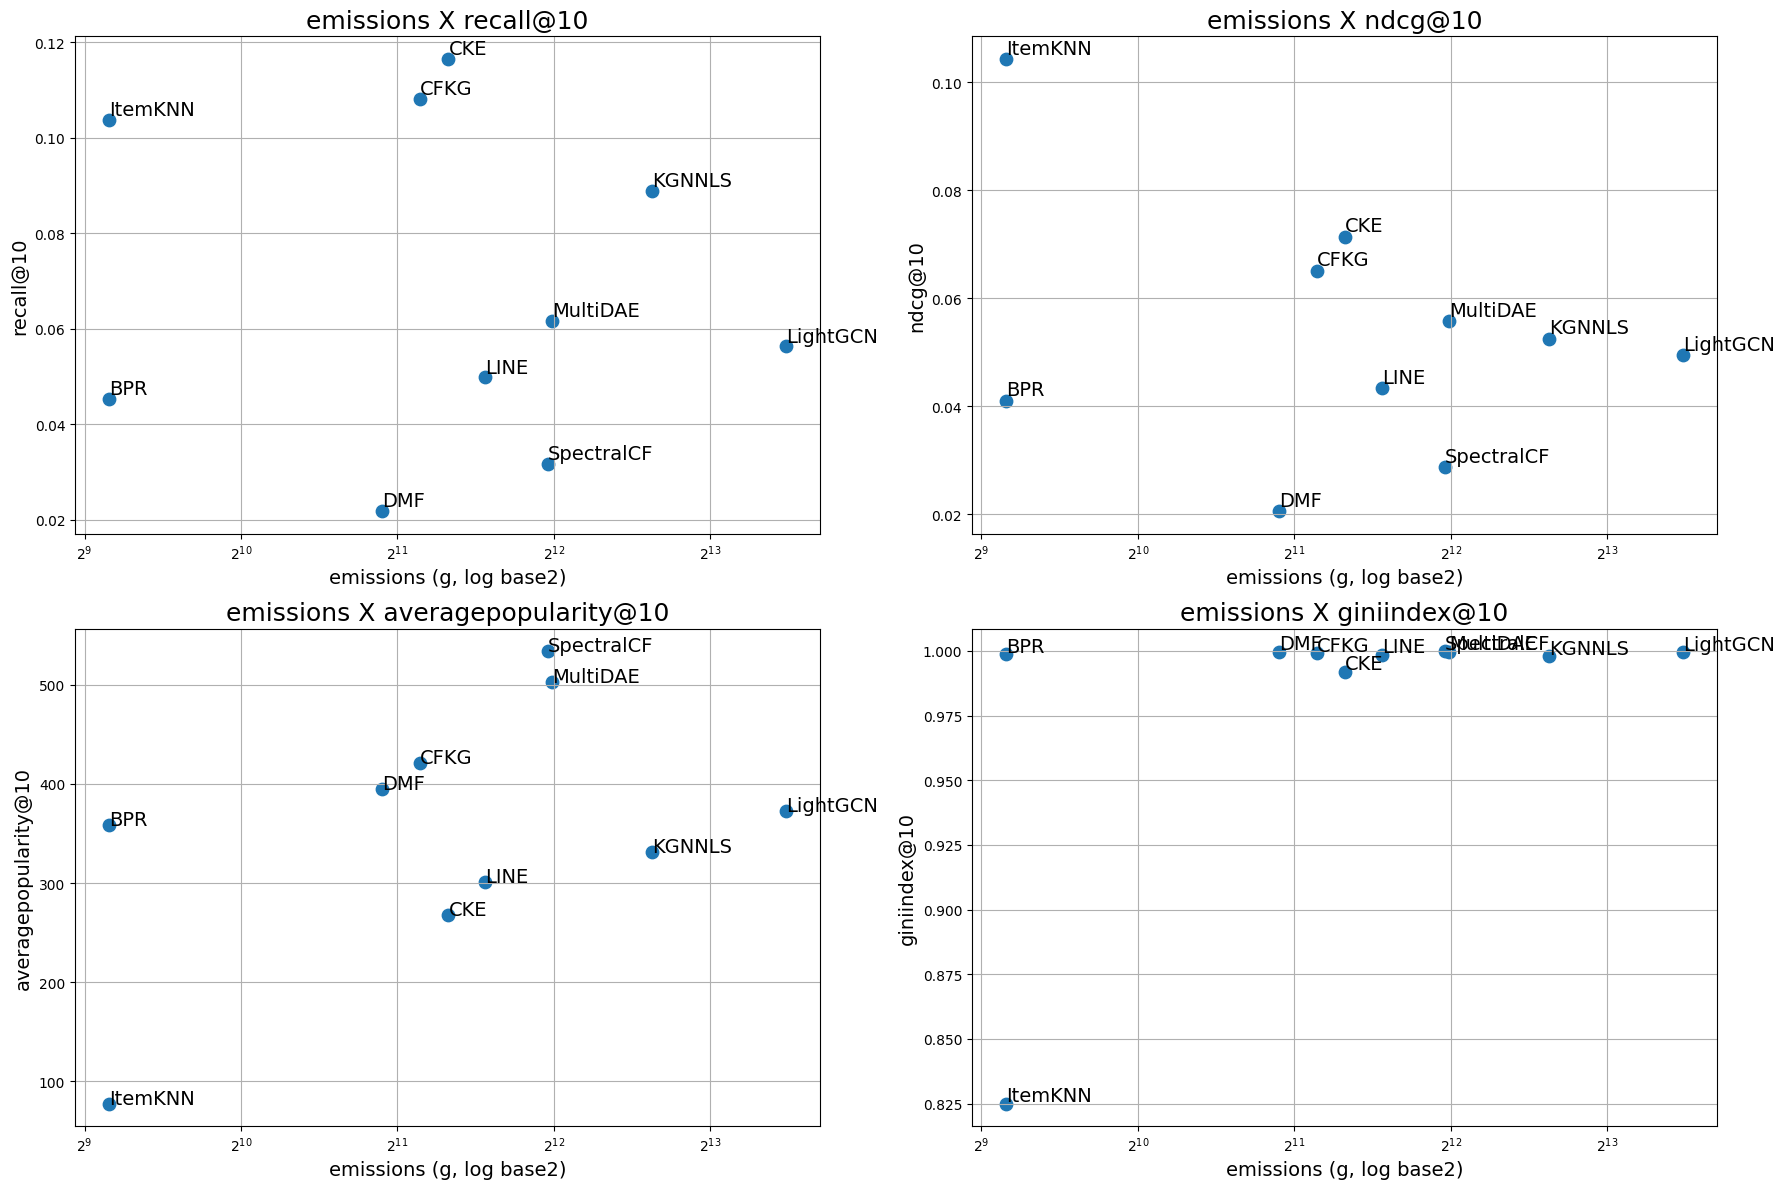

In [19]:
plot_tradeoff(results, metrics, experiments)

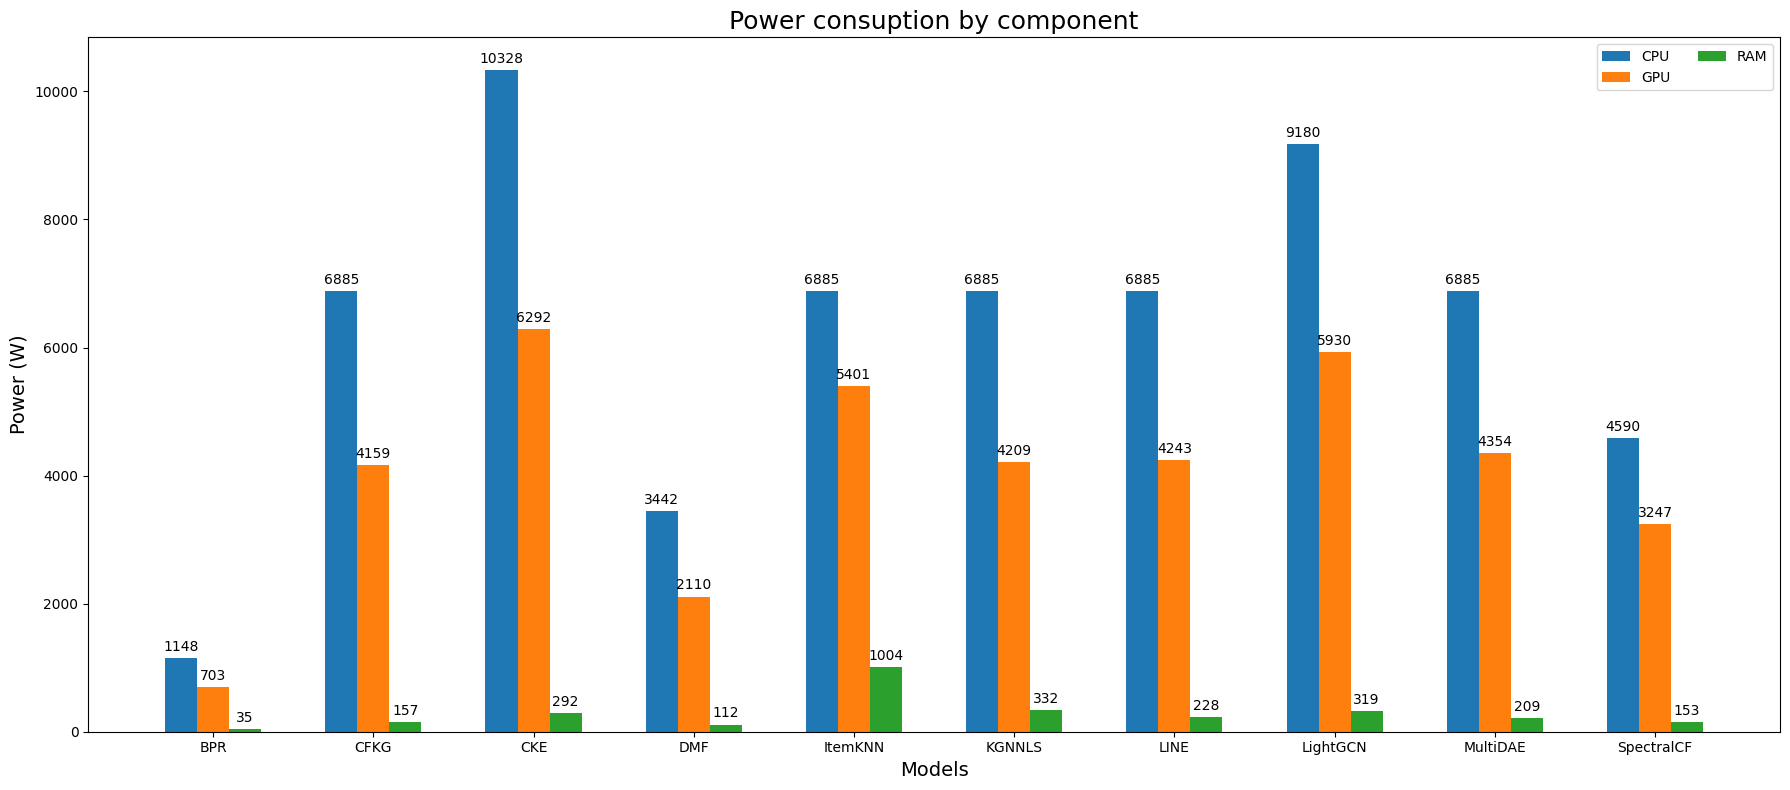

In [20]:
plot_power(results, experiments)

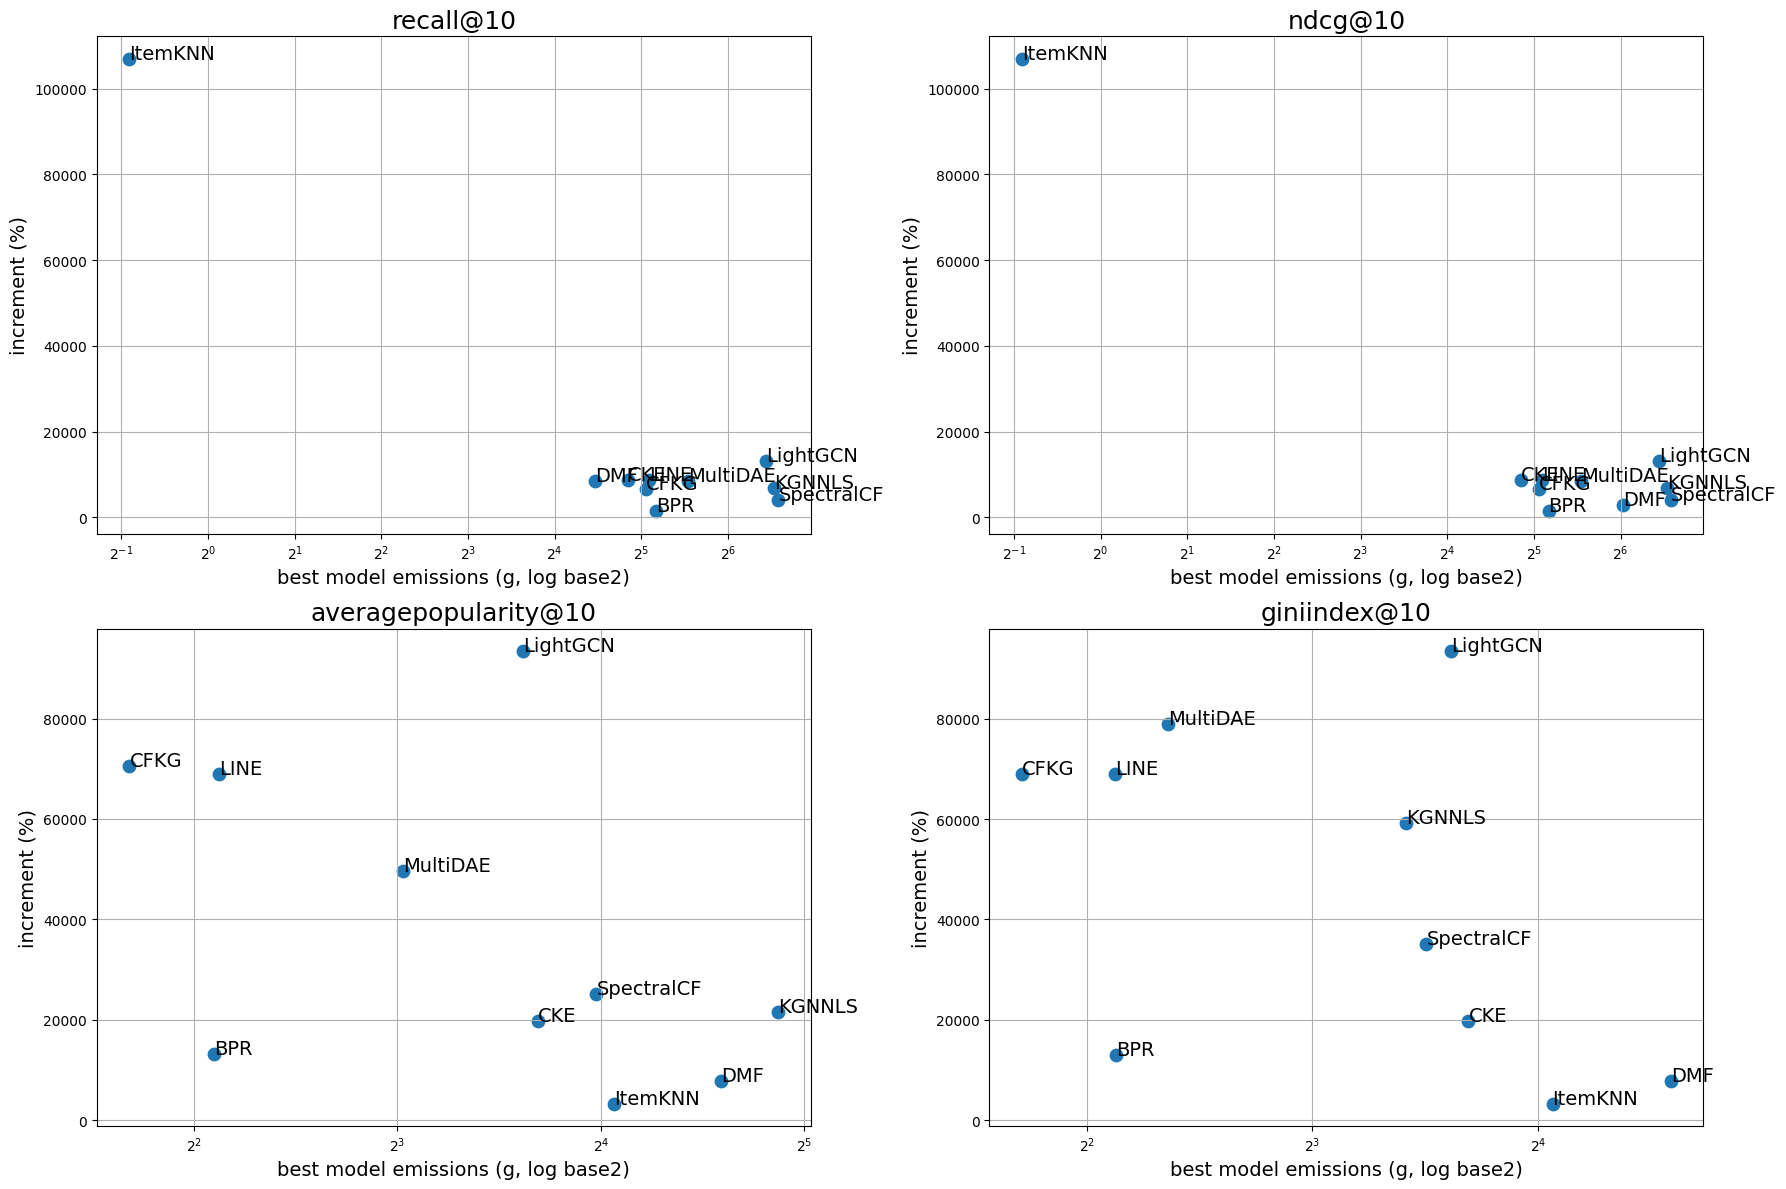

In [21]:
plot_tradeoff_by_increment(best, experiments)

In [22]:
print_best_metrics(results, best, experiments)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET      MODEL       BEST_METRIC by INCR.    BEST_RUN(g)       TOTAL(g)   INCREMENT(%)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
1    amazon_books BPR         recall@10                   35.9466        571.757           1491
1    amazon_books BPR         mrr@10                      35.9466        571.757           1491
1    amazon_books BPR         ndcg@10                     35.9466        571.757           1491
1    amazon_books BPR         hit@10                      35.9466        571.757           1491
1    amazon_books BPR         map@10                      35.9466        571.757           1491
1    amazon_books BPR         precision@10                35.9466        571.757           1491

2    amazon_books CFKG        gauc                        33.7018       2266.538           6625

3    amazon_books CKE     

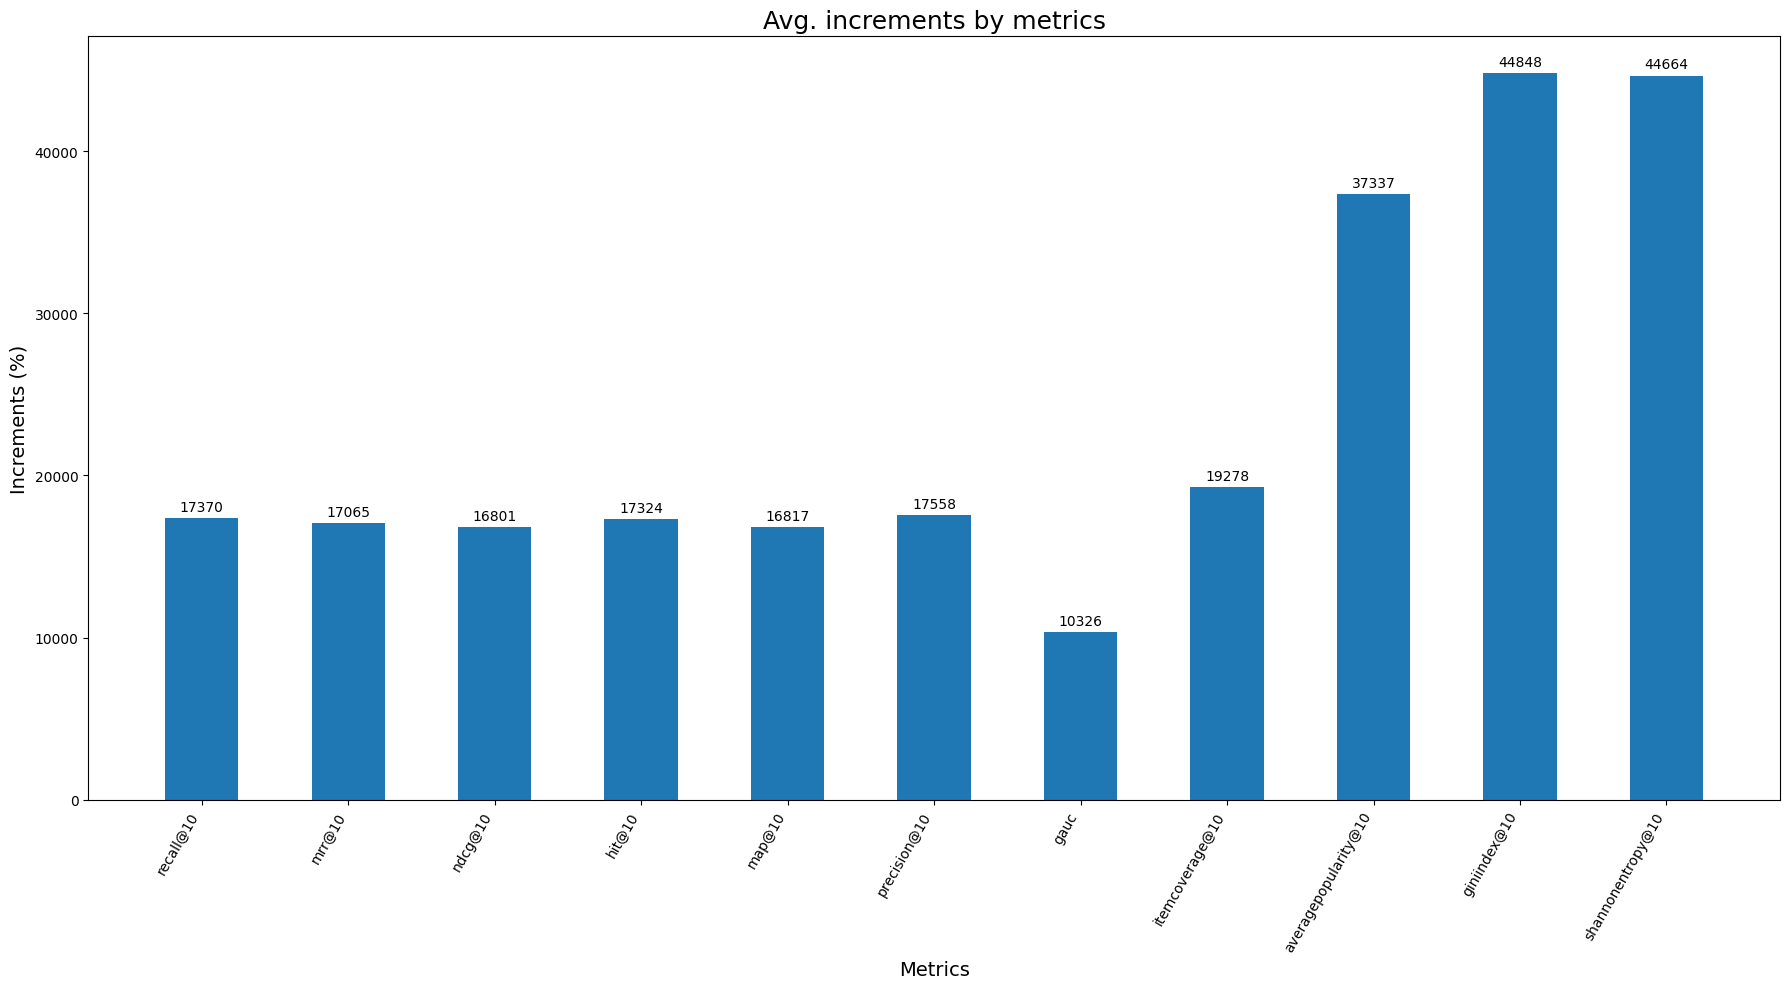

In [23]:
plot_increments_by_metrics(best)